In [2]:
cd ../src

/workspace/Script/Computer Vision/Identify Contrails/src


In [3]:
import os
import gc
import json
import time
import torch
import joblib
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings("ignore")

In [4]:
import albumentations as A

In [5]:
DATA_PATH = Path(r"/database/kaggle/Identify Contrails/data")
CHECKPOINT_PATH = Path(r"/database/kaggle/Identify Contrails/checkpoint")

os.listdir(DATA_PATH)

['20230419_tfrecords_train.tfrecords-00000-of-00100',
 'ABI-L1b-RadC_2023_009_00_OR_ABI-L1b-RadC-M6C01_G16_s20230090001171_e20230090003545_c20230090004009.nc',
 '3c_all_images',
 'host_images',
 'validation',
 'test',
 'train_metadata.json',
 'train',
 'df_6c.csv',
 'validation_metadata.json',
 'ABI-L1b-RadC_2019_001_01_OR_ABI-L1b-RadC-M3C01_G16_s20190010102187_e20190010104560_c20190010105005.nc',
 'df.csv',
 'oof',
 'psl',
 'sample_submission.csv']

In [6]:
df = pd.read_csv(DATA_PATH/'df.csv')
df.shape

(22385, 15)

In [7]:
df['file_name'] = str(DATA_PATH/"3c_all_images/")+'/'+df['record_id'].astype(str)+'.npy'

In [8]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [9]:
def get_training_augmentation(resize_to=(320,640), crop_size=(288,576)):
    print('[get_training_augmentation] crop_size:', crop_size, ', resize_to:', resize_to) 

    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
#         albu.ShiftScaleRotate(scale_limit=0.20, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
        albu.GridDistortion(p=0.5),
        albu.Resize(*resize_to),
        albu.RandomCrop(*crop_size),
        albu.ChannelShuffle(),
        albu.InvertImg(),
        albu.ToGray(),
        albu.Normalize(),
    ]

    return albu.Compose(train_transform)

In [10]:
import cv2

In [11]:
transform = A.Compose([
#     A.RandomCrop(width=256, height=256,p=1),
#     A.HorizontalFlip(p=1),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=1),
#     A.RandomBrightnessContrast(p=0.2),
#     A.RandomContrast(p=0.2)
#     A.ShiftScaleRotate(scale_limit=0.20, rotate_limit=10, shift_limit=0.1, p=1),
#     A.GridDistortion(p=0.5),
    A.RandomSizedCrop(min_max_height=(64, 128), height=256, width=256, p=1),
#     A.ChannelShuffle(p=1),
#     A.InvertImg(p=1),
#     A.ToGray(p=1),
    
])

In [12]:
row = df[(df.data=="train") & (df.nb_labels>200)].sample(1).reset_index(drop=True).iloc[0]
row

record_id                                         5188922182265887843
row_min                                                   690412.3750
row_size                                                   -1950.5249
col_min                                                   364657.7812
col_size                                                    1953.2190
timestamp                                         2020-02-01 06:40:00
central_meridian                                                  -57
data                                                            train
month_name                                                   February
year                                                             2020
hour                                                                6
is_day                                                              0
file_name           /database/kaggle/Identify Contrails/data/3c_al...
annot                                                          4.0000
nb_labels           

In [13]:
img = np.load(str(row.file_name).split('.npy')[0]+".npy").astype(np.float32)
img.shape

(256, 256, 3, 8)

In [14]:
labels = np.load(f"/database/kaggle/Identify Contrails/data/train/{row.record_id}/human_individual_masks.npy").astype(np.float16)
labels.shape

(256, 256, 1, 4)

In [15]:
labels.squeeze().shape

(256, 256, 4)

In [16]:
def visualize_rec(record_id):

    img = np.load(DATA_PATH/f"host_images/{record_id}_all.npy").astype(np.float32)
    human_pixel_mask = np.load(DATA_PATH/f"train/{record_id}/human_pixel_masks.npy").astype(np.float16)

    plt.figure(figsize=(20, 10))
    for i in range(9):
        ax = plt.subplot(2, 5, i+1)
        j = 0 if i<8 else 1
        i = i if i <8 else 4
        ax.imshow(img[...,i])
        if (i==4) and (j==0):
            ax.imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
        ax.set_title(f'Image {i+1}')

def visualize_labels(record_id):
    human_individual_mask = np.load(DATA_PATH/f"train/{record_id}/human_individual_masks.npy").astype(np.float16)
    n = human_individual_mask.shape[-1]
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(human_individual_mask[..., i], interpolation='none')
        
        
def visualize_pred(df,preds,record_id):
    
    idx = df[df.record_id.astype(str)==record_id].index
#     print(idx)
    img = np.load(DATA_PATH/f"host_images/{record_id}_all.npy").astype(np.float32)
    human_pixel_mask = (preds[idx].numpy().astype(np.float16)>=0.5)*1
    human_pixel_mask = human_pixel_mask.squeeze(0)
    print(dice(torch.tensor(human_pixel_mask[4]),y_true.squeeze()[idx].long(),threshold=0.5).item())
#     print(human_pixel_mask.shape)
    plt.figure(figsize=(20, 10))
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        ax.imshow(img[...,i])
        ax.imshow(human_pixel_mask[i], cmap='Reds', alpha=.4, interpolation='none')
        ax.set_title(f'Image {i+1}')

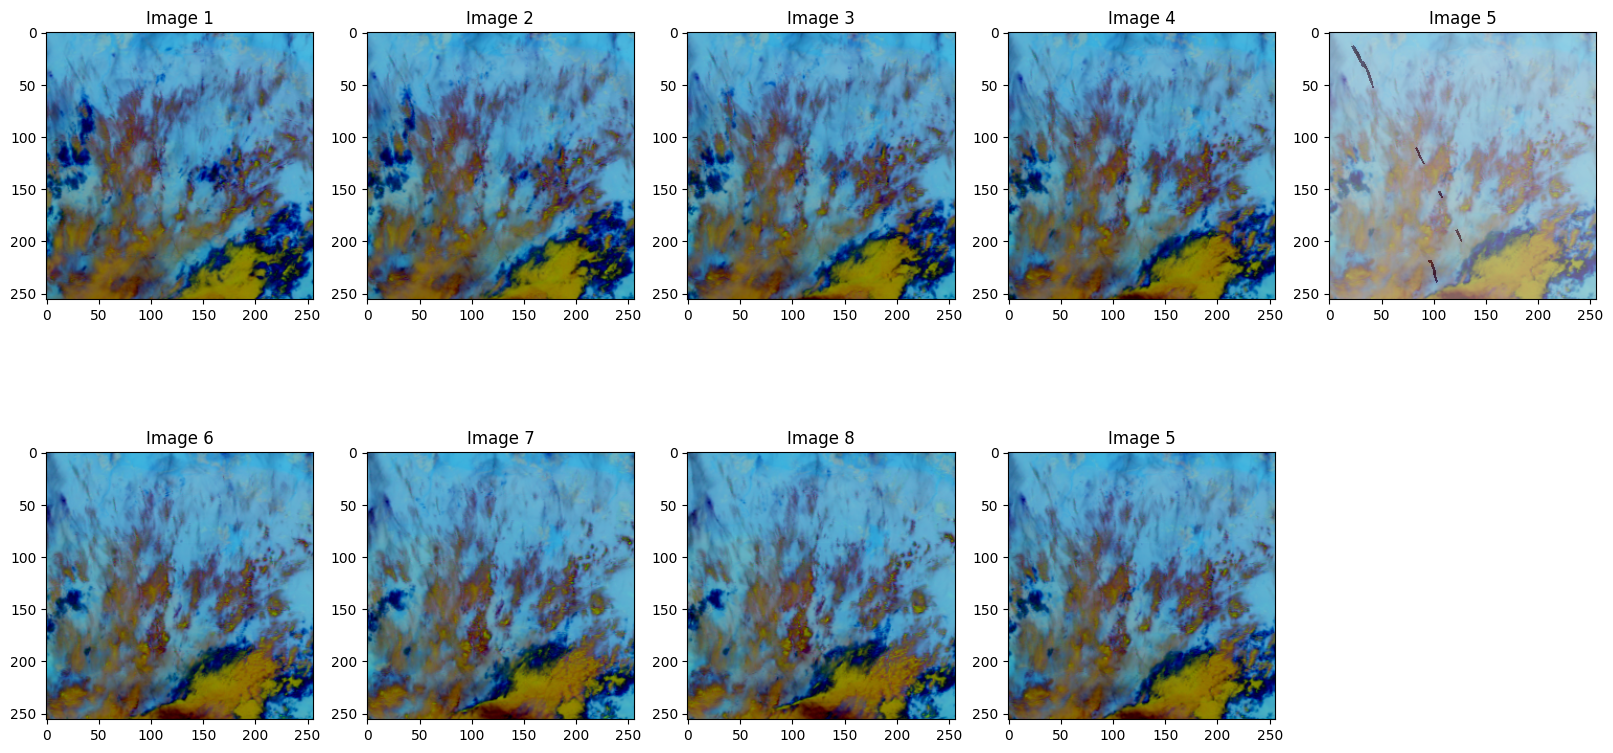

In [17]:
visualize_rec(row.record_id)

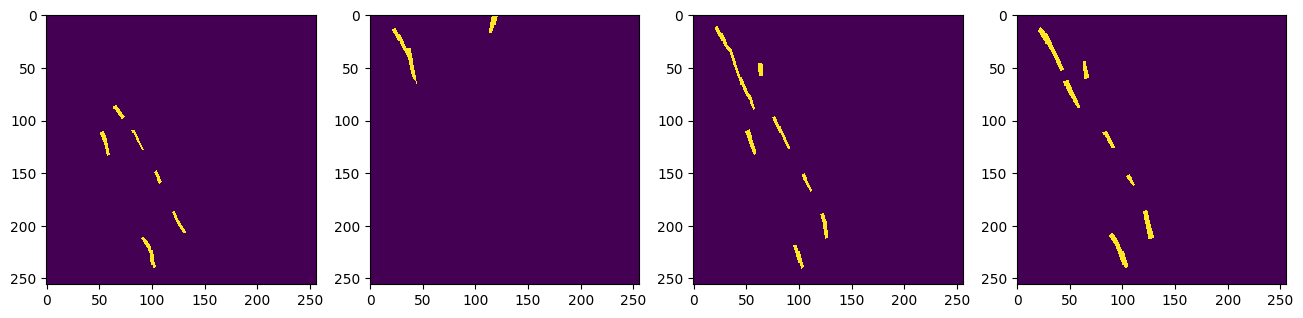

In [18]:
visualize_labels(row.record_id)

In [19]:
masks = np.load(DATA_PATH/f"train/{row.record_id}/human_pixel_masks.npy").astype(np.float16)
masks.shape

(256, 256, 1)

In [20]:
img_4 = img[...,4]
img_4.shape

(256, 256, 3)

In [58]:
transformed = transform(image=img_4, mask=masks)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

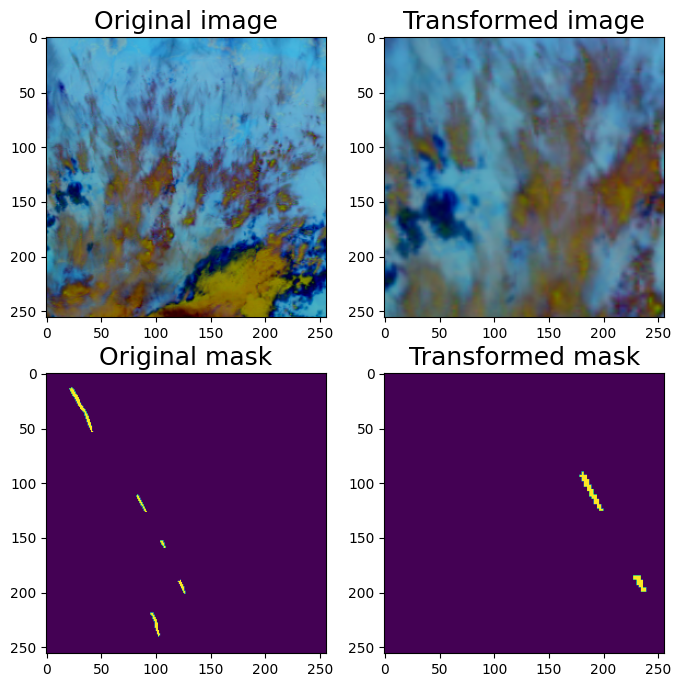

In [59]:
visualize(transformed_image, transformed_mask, original_image=img_4, original_mask=masks.squeeze())

# GET BBOX

In [141]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

In [142]:
ASSETS_DIRECTORY = "assets"

plt.rcParams["savefig.bbox"] = "tight"

In [143]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [144]:
from torchvision.utils import draw_segmentation_masks

In [145]:
mask = torch.tensor(masks).to(torch.int).permute(2,0,1)
mask.shape

torch.Size([1, 256, 256])

In [146]:
imgt = torch.tensor(img_4).to(torch.uint8).permute(2,0,1)
imgt.shape

torch.Size([3, 256, 256])

In [147]:
# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
maskss = mask == obj_ids[:, None, None]
maskss.shape

torch.Size([1, 256, 256])

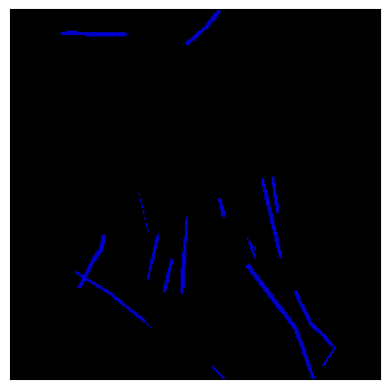

In [148]:
drawn_masks = []
for mask in maskss:
    drawn_masks.append(draw_segmentation_masks(imgt, mask, alpha=0.8, colors="blue"))

show(drawn_masks)

In [149]:
from torchvision.ops import masks_to_boxes

In [150]:
boxes = masks_to_boxes(maskss)
print(boxes.size())
print(boxes)

torch.Size([1, 4])
tensor([[ 35.,   0., 224., 255.]])


In [151]:
from torchvision.utils import draw_bounding_boxes

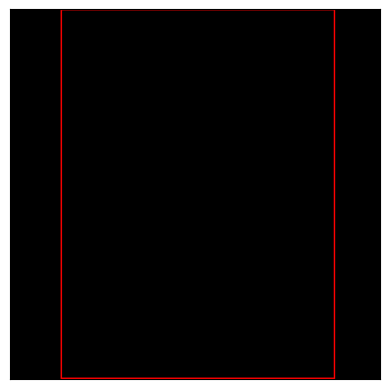

In [152]:
drawn_boxes = draw_bounding_boxes(imgt, boxes, colors="red")
show(drawn_boxes)

In [60]:
import os
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
# from skimage.util.montage import montage2d as montage
# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

In [61]:
mask_0 = masks
mask_0.shape,img_4.shape

((256, 256, 1), (256, 256, 3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found bbox (13, 21, 54, 43)
Found bbox (111, 82, 127, 92)
Found bbox (153, 104, 160, 109)
Found bbox (189, 120, 202, 127)
Found bbox (219, 95, 241, 104)


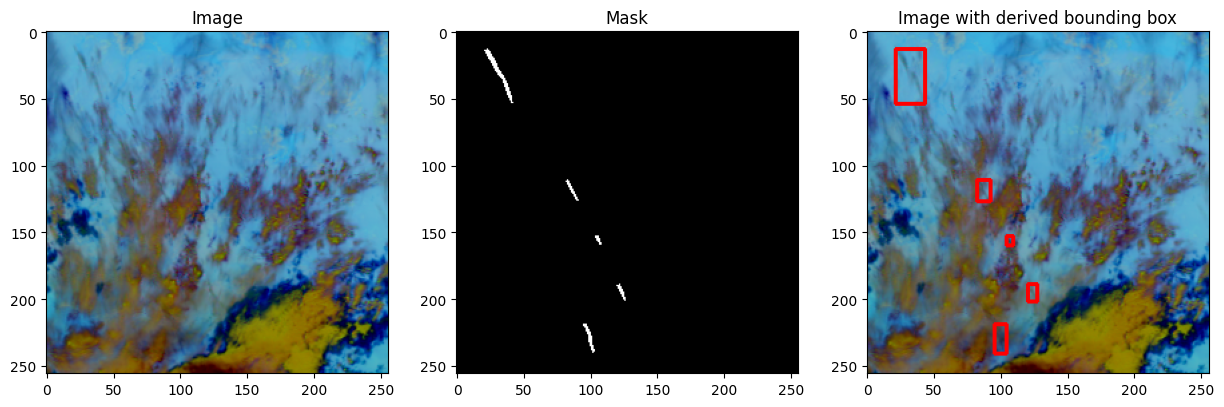

In [62]:
lbl_0 = label(mask_0.squeeze()) 
props = regionprops(lbl_0)
img_1 = img_4.copy()
img_0 = img_4.copy()
# print ('Image', image)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
for prop in props:
    print('Found bbox', prop.bbox)
    cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


ax1.imshow(img_0)
ax1.set_title('Image')
ax2.set_title('Mask')
ax3.set_title('Image with derived bounding box')
ax2.imshow(mask_0[...,0], cmap='gray')
ax3.imshow(img_1)
plt.show()

In [64]:
bboxes = []
for prop in props:
    bboxes.append(prop.bbox)

In [65]:
# prop.bbox[1]

In [66]:
bboxes

[(13, 21, 54, 43),
 (111, 82, 127, 92),
 (153, 104, 160, 109),
 (189, 120, 202, 127),
 (219, 95, 241, 104)]

In [70]:
mask_0.shape

(256, 256, 1)

In [79]:
idx = 3
mask_0.squeeze()[bboxes[idx][0]:bboxes[idx][2],bboxes[idx][1]:bboxes[idx][3]]

array([[0., 0., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float16)

In [76]:
img_1[...,2].squeeze()[bboxes[1][0]:bboxes[1][2],bboxes[1][1]:bboxes[1][3]]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.3774414 , 0.4946289 , 0.5214844 ,
        0.47314453, 0.5024414 , 0.5830078 , 0.63623047, 0.        ],
       [0.        , 0.        , 0.40698242, 0.4033203 , 0.45092773,
        0.46850586, 0.4880371 , 0.5415039 , 0.61083984, 0.        ],
       [0.        , 0.        , 0.4560547 , 0.39038086, 0.42529297,
        0.50878906, 0.53466797, 0.56591797, 0.62646484, 0.        ],
       [0.        , 0.        , 0.4338379 , 0.41333008, 0.40185547,
        0.54785156, 0.5917969 , 0.61083984, 0.6489258 , 0.        ],
       [0.        , 0.        , 0.39111328, 0.40014648, 0.4104004 ,
        0.56933594, 0.62939453, 0.65234375, 0.68115234, 0.        ],
       [0.        , 0.        , 0.3540039

In [ ]:
for i in range(10):
    image = images_with_ship[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()